In [1]:
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500) 

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import torch
from transformers import AutoTokenizer, AutoModel

tqdm.pandas()

device = torch.device('cuda')

/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
data = pd.read_csv('/home/admin01/vadim/classifier/Таблица_данные_опроса_+_часть_из_обогащения.csv')
data = data.drop(columns=['ИНН_x', 'ИНН_y', 'Степень уверенности', 'Кол-во вариантов с таким названием компании'])

In [51]:
num_cols = ['Уставный капитал, сумма', 'Среднесписочная численность сотрудников', 'Сумма уплаченных налогов за 2020', 'age']

cat_cols = ['Вид экономической деятельности, ОКВЭД', 
            'Доп вид экономической деятельности_1',
            'Доп вид экономической деятельности_2', 
            'Доп вид экономической деятельности_3',
            'Уставный капитал, тип',
            'Тип по ОКОГУ',
            'Категория из реестра СМП'
            ]

In [52]:
data

,Номер,Пол,Дата рождения,Федеральный округ,Регион,Страна проживания,Место работы,Наименование текущей должности,Уровень образования,Карьерная ступень по Классификатору ФОИР,Наименование выбранной типовой должности,Сфера деятельности по Классификатору ФОИР,Соответствует ли выбранная типовая текущей должности,Ручная проверка карьерной ступени,Разница по итогам проверки,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип","Уставный капитал, сумма",Тип по ОКОГУ,Среднесписочная численность сотрудников,Категория из реестра СМП,Сумма уплаченных налогов за 2020
0,9886272994,Мужской,28.05.1980,Центральный ФО,Московская,Россия,"ООО ""РЖД-Технологии""",Директор по стратегии,Кандидат наук,1,Руководитель подразделения/группы/команды на м...,"Коммерческие компании, государственные/муницип...",Можно считать аналогом с очень большой натяжкой,NaN,NaN,Деятельность консультативная и работы в област...,"Торговля оптовая компьютерами, периферийными у...",Торговля оптовая неспециализированная,"Торговля розничная компьютерами, периферийными...",УСТАВНЫЙ КАПИТАЛ,195198000.0,"Организации, учрежденные юридическими лицами и...",89.0,NaN,2.016288e+08
1,8010695393,Мужской,09.10.1977,Центральный ФО,Орловская,Россия,ПАО МегаФон,начальник,Два и более высших образований,3,Руководитель проекта в крупной/средней компании,"Коммерческие компании, государственные/муницип...",Очень близкий аналог,NaN,NaN,Деятельность в области связи на базе проводных...,Торговля оптовая программным обеспечением,Торговля оптовая неспециализированная,Деятельность в области связи на базе беспровод...,УСТАВНЫЙ КАПИТАЛ,62000000.0,Хозяйственные общества и товарищества с участи...,NaN,NaN,NaN
2,4851605917,Мужской,08.12.1991,Уральский ФО,Свердловская,Россия,"ООО ""Генная Хирургия""",Исполнительный директор,Два и более высших образований,5,"Генеральный директор, управляющий директор мал...","Коммерческие компании, государственные/муницип...",Полный аналог,NaN,NaN,Научные исследования и разработки в области ес...,Производство фармацевтических субстанций,Производство лекарственных препаратов и матери...,"Производство посуды для лабораторных, фармацев...",УСТАВНЫЙ КАПИТАЛ,84000.0,"Организации, учрежденные юридическими лицами и...",0.0,МИКРОПРЕДПРИЯТИЕ,1.057117e+06
3,8490491075,Мужской,25.05.1968,Уральский ФО,Свердловская,Россия,Информационно-Туристический центр Свердловской...,президент,Два и более высших образований,5,Президент/председатель общественной организаци...,Общественные/общественно-политические организа...,Полный аналог,NaN,NaN,Деятельность в области права,Исследование конъюнктуры рынка и изучение обще...,NaN,NaN,NaN,NaN,"Организации, учрежденные юридическими лицами и...",NaN,NaN,NaN
4,7420276560,Мужской,31.10.1990,Северо-Западный ФО,Санкт-Петербург,Россия,Газпромнефть-ЦР,TeamLead,"Высшее, специалитет, магистратура",3,Руководитель проекта в крупной/средней компании,"Коммерческие компании, государственные/муницип...",Можно считать аналогом с очень большой натяжкой,NaN,NaN,Разработка компьютерного программного обеспечения,Ремонт электронного и оптического оборудования,Деятельность консультативная и работы в област...,"Деятельность, связанная с использованием вычис...",УСТАВНЫЙ КАПИТАЛ,10000000.0,"Публичное акционерное общество ""Газпром нефть""",4386.0,NaN,4.345360e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,1482168663,Женский,10.07.1986,Центральный ФО,Владимирская,Россия,Законодательное Собрание Владимирской области,Советник Председателя Законодательного Собрани...,"Высшее, специалитет, магистратура",2,"Советник, помощник, референт, главный специали...","Региональные органы государственной власти, в ...",Можно считать аналогом с очень большой натяжкой,NaN,NaN,Деятельность органов государственной власти су...,NaN,NaN,NaN,NaN,NaN,Законодательная (представительная) власть су...,NaN,NaN,NaN
16923,17

In [53]:
data.nunique()

Номер                                                   16927
Пол                                                         2
Дата рождения                                            8104
Федеральный округ                                           8
Регион                                                     85
Страна проживания                                          31
Место работы                                            14601
Наименование текущей должности                           9708
Уровень образования                                        10
Карьерная ступень по Классификатору ФОИР                   12
Наименование выбранной типовой должности                  163
Сфера деятельности по Классификатору ФОИР                   8
Соответствует ли выбранная типовая текущей должности        5
Ручная проверка карьерной ступени                          10
Разница по итогам проверки                                  8
Вид экономической деятельности, ОКВЭД                    1108
Доп вид 

In [54]:
data['Среднесписочная численность сотрудников'].value_counts()

Среднесписочная численность сотрудников
1.0      408
2.0      208
3.0      161
0.0      130
4.0      112
        ... 
255.0      1
730.0      1
598.0      1
662.0      1
288.0      1
Name: count, Length: 769, dtype: int64

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16927 entries, 0 to 16926
Data columns (total 25 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Номер                                                 16927 non-null  int64  
 1   Пол                                                   16797 non-null  object 
 2   Дата рождения                                         16797 non-null  object 
 3   Федеральный округ                                     16675 non-null  object 
 4   Регион                                                16671 non-null  object 
 5   Страна проживания                                     16721 non-null  object 
 6   Место работы                                          16927 non-null  object 
 7   Наименование текущей должности                        16927 non-null  object 
 8   Уровень образования                                   16

In [143]:
from dadata import Dadata

In [56]:
tasks = ['Сфера деятельности по Классификатору ФОИР', 'Карьерная ступень по Классификатору ФОИР']

In [57]:
data['Дата рождения'] = pd.to_datetime(data['Дата рождения'], format="%d.%m.%Y")
data['age'] = pd.Timestamp('now').year - data['Дата рождения'].dt.year


LE = [LabelEncoder(), LabelEncoder()]
data['label_a'] = LE[0].fit_transform(data[tasks[0]])
data['label_b'] = LE[1].fit_transform(data[tasks[1]])

text_cols  = ['Место работы', 'Наименование текущей должности']
cat_cols += ['Пол', 'Регион', 'Страна проживания', 'Уровень образования', 'Федеральный округ']
data[text_cols] = data[text_cols].fillna('Пропущенное значение')

# Поменять на df_test и добавить val (10-15%)

In [126]:
data['Пол'].value_counts()

Пол
Мужской    11845
Женский     4952
Name: count, dtype: int64

In [138]:
data['Уровень образования'].value_counts().index.tolist()

['Высшее, специалитет, магистратура',
 'Два и более высших образований',
 'Высшее, бакалавриат',
 'Кандидат наук',
 'Высшее образование и MBA',
 'Незаконченное высшее',
 'Студент выпускного курса специалитета/магистратуры',
 'Среднее профессиональное',
 'Доктор наук',
 'Среднее общее']

In [137]:
data['Регион'].value_counts()[:100].index.tolist()

['Москва',
 'Санкт-Петербург',
 'Московская',
 'Свердловская',
 'Краснодарский',
 'Татарстан',
 'Самарская',
 'Башкортостан',
 'Новосибирская',
 'Нижегородская',
 'Тюменская',
 'Челябинская',
 'Ростовская',
 'Красноярский',
 'Ханты-Мансийский Автономный округ - Югра',
 'Пермский',
 'Иркутская',
 'Ставропольский',
 'Воронежская',
 'Ямало-Ненецкий',
 'Саратовская',
 'Ленинградская',
 'Кемеровская',
 'Белгородская',
 'Волгоградская',
 'Омская',
 'Мурманская',
 'Дагестан',
 'Приморский',
 'Удмуртская',
 'Томская',
 'Хабаровский',
 'Крым',
 'Ярославская',
 'Калининградская',
 'Калужская',
 'Алтайский',
 'Липецкая',
 'Кировская',
 'Оренбургская',
 'Смоленская',
 'Рязанская',
 'Тульская',
 'Бурятия',
 'Пензенская',
 'Севастополь',
 'Саха ( Якутия )',
 'Архангельская',
 'Вологодская',
 'Чувашская',
 'Коми',
 'Владимирская',
 'Тверская',
 'Ивановская',
 'Мордовия',
 'Новгородская',
 'Ульяновская',
 'Кабардино-Балкарская',
 'Орловская',
 'Забайкальский',
 'Курская',
 'Костромская',
 'Карачаево-Ч

In [141]:
data['Наименование выбранной типовой должности'].value_counts()

Наименование выбранной типовой должности
Руководитель подразделения (начальник отдела) на среднем предприятии/организации (региональный уровень/средний бизнес)                               1258
Руководитель подразделения/группы/команды на малом предприятии/организации (малый бизнес)                                                            1248
Руководитель структурного подразделения (начальник отдела)/группы/команды на крупном предприятии/организации (федеральный уровень/крупный бизнес)    1246
Руководитель проекта в крупной/средней компании                                                                                                       939
Директор малого предприятия                                                                                                                           763
                                                                                                                                                     ... 
Заместитель руководителя сверхкрупн

In [120]:
data.nunique()

Номер                                                   16927
Пол                                                         2
Дата рождения                                            8104
Федеральный округ                                           8
Регион                                                     85
Страна проживания                                          31
Место работы                                            14601
Наименование текущей должности                           9708
Уровень образования                                        10
Карьерная ступень по Классификатору ФОИР                   12
Наименование выбранной типовой должности                  163
Сфера деятельности по Классификатору ФОИР                   8
Соответствует ли выбранная типовая текущей должности        5
Ручная проверка карьерной ступени                          10
Разница по итогам проверки                                  8
Вид экономической деятельности, ОКВЭД                    1108
Доп вид 

In [122]:
df['Страна проживания'].value_counts()

Страна проживания
Россия                16476
Украина                  53
Казахстан                10
Беларусь                  9
Киргизия                  6
Американское Самоа        5
Австралия                 3
Узбекистан                3
Алжир                     3
Австрия                   3
Марокко                   2
Латвия                    2
Турция                    2
Туркменистан              2
Албания                   2
Армения                   2
Индия                     1
Грузия                    1
Бразилия                  1
Ливан                     1
Болгария                  1
Гамбия                    1
Вьетнам                   1
Азербайджан               1
Германия                  1
Венесуэла                 1
Сербия                    1
США                       1
Таджикистан               1
Ирак                      1
Боливия                   1
Name: count, dtype: int64

In [58]:
cat_cols

['Вид экономической деятельности, ОКВЭД',
 'Доп вид экономической деятельности_1',
 'Доп вид экономической деятельности_2',
 'Доп вид экономической деятельности_3',
 'Уставный капитал, тип',
 'Тип по ОКОГУ',
 'Категория из реестра СМП',
 'Пол',
 'Регион',
 'Страна проживания',
 'Уровень образования']

In [59]:
df = data.copy()

df_test = df[df['Ручная проверка карьерной ступени'].notna()][cat_cols + text_cols + num_cols ]
y_test = [df[df['Ручная проверка карьерной ступени'].notna()]['label_a'], 
          df[df['Ручная проверка карьерной ступени'].notna()]['label_b']]

df = df[df['Ручная проверка карьерной ступени'].isna()]
df_train, df_val = train_test_split(df, test_size=.20)

y_train = [df_train['label_a'], df_train['label_b']]
df_train = df_train[cat_cols + text_cols + num_cols].copy()

y_val = [df_val['label_a'], df_val['label_b']]
df_val = df_val[cat_cols + text_cols + num_cols].copy()

In [60]:
df_train.columns

Index(['Вид экономической деятельности, ОКВЭД',
       'Доп вид экономической деятельности_1',
       'Доп вид экономической деятельности_2',
       'Доп вид экономической деятельности_3', 'Уставный капитал, тип',
       'Тип по ОКОГУ', 'Категория из реестра СМП', 'Пол', 'Регион',
       'Страна проживания', 'Уровень образования', 'Место работы',
       'Наименование текущей должности', 'Уставный капитал, сумма',
       'Среднесписочная численность сотрудников',
       'Сумма уплаченных налогов за 2020', 'age'],
      dtype='object')

In [61]:
df_val

,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип",Тип по ОКОГУ,Категория из реестра СМП,Пол,Регион,Страна проживания,Уровень образования,Место работы,Наименование текущей должности,"Уставный капитал, сумма",Среднесписочная численность сотрудников,Сумма уплаченных налогов за 2020,age
1724,Деятельность органов государственной власти су...,Предоставление услуг в области лесоводства,Предоставление услуг в области лесозаготовок,NaN,NaN,Органы исполнительной власти субъектов Российс...,NaN,Женский,Пензенская,Россия,"Высшее, специалитет, магистратура",ГКУ ПО КУЗНЕЦКОЕ ЛЕСНИЧЕСТВО,"Специалист по кадрам, контрактный управляющий",NaN,NaN,NaN,39.0
3177,Деятельность в области обязательного социально...,NaN,NaN,NaN,NaN,Пенсионный фонд Российской Федерации,NaN,Мужской,Московская,Россия,Два и более высших образований,Государственное учреждение - Главное управлени...,Начальник главного управления,NaN,NaN,NaN,42.0
505,Государственное регулирование деятельности в о...,"Деятельность по обработке данных, предоставлен...",Деятельность по созданию и использованию баз д...,NaN,NaN,Министерство строительства и жилищно-коммуналь...,NaN,Мужской,Ульяновская,Россия,Два и более высших образований,"Федеральное казенное учреждение ""Объединенная ...",Начальник отдела правового обеспечения реализа...,NaN,NaN,NaN,51.0
724,Деятельность вспомогательная прочая в сфере фи...,"Издание книг, брошюр, рекламных буклетов и ана...",Аренда и управление собственным или арендованн...,Деятельность по оказанию услуг в области бухга...,NaN,"Организации, учрежденные юридическими лицами и...",NaN,Мужской,Москва,Россия,Два и более высших образований,"АНО ""Агентство инвестиционного развития Москов...",Директор Департамента проектного развития терр...,NaN,NaN,NaN,36.0
14191,Торговля электроэнергией,Производство электромонтажных работ,Деятельность по складированию и хранению,Деятельность в области связи на базе проводных...,NaN,Приватизированные предприятия,NaN,Мужской,Карачаево-Черкесская,Россия,"Высшее, специалитет, магистратура","Акционерное общество ""Карачаево-Черкесскэнерго""",Начальник отдела корпоративного управления и п...,NaN,51.0,5.958054e+06,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,"Производство теплообменных устройств, оборудов...",Производство прочих машин и оборудования общег...,Ремонт машин и оборудования,Строительство жилых и нежилых зданий,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",СРЕДНЕЕ ПРЕДПРИЯТИЕ,Мужской,Санкт-Петербург,Россия,"Высшее, специалитет, магистратура","ООО НПО ""ЭТРА""",руководитель обособленного подразделения,2.000000e+04,124.0,1.535733e+08,35.0
11617,Разработка компьютерного программного обеспечения,Деятельность консультативная и работы в област...,"Деятельность, связанная с использованием вычис...","Деятельность по обработке данных, предоставлен...",УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,Мужской,Московская,Россия,"Высшее, специалитет, магистратура",СИГМА (АйТи),Ведущий эксперт,1.000000e+05,NaN,NaN,37.0
1048,"Производство прочих продуктов питания, не вклю...",Переработка и консервирование мяса,Производство и консервирование мяса птицы,Производство продукции из мяса убойных животны...,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,Мужской,Тульская,Россия,"Высшее, специалитет, магистратура","ООО ""Алхимия Лаб""",Главный технолог,5.000000e+04,5.0,9.139243e+05,39.0
7910,Деятельность органов местного самоуправления п...,NaN,NaN,NaN,NaN,Местные администрации (исполнительно-распоряди...,NaN,Женский,Московская,Россия,"Высшее, специалитет, магистратура",Администрация городского округа Власиха,Первый заместитель главы,NaN,NaN,NaN,41.0


In [62]:
df_test

,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип",Тип по ОКОГУ,Категория из реестра СМП,Пол,Регион,Страна проживания,Уровень образования,Место работы,Наименование текущей должности,"Уставный капитал, сумма",Среднесписочная численность сотрудников,Сумма уплаченных налогов за 2020,age
7,Деятельность прочих общественных организаций и...,Деятельность в области права,Научные исследования и разработки в области об...,NaN,NaN,"Организации, учрежденные юридическими лицами и...",NaN,Мужской,Москва,Россия,"Высшее, специалитет, магистратура",Общероссийский Конгресс муниципальных образований,заместитель исполнительного директора,NaN,NaN,NaN,38.0
8,Деятельность федеральных органов государственн...,NaN,NaN,NaN,NaN,Федеральная служба по надзору в сфере образова...,NaN,Мужской,Москва,Россия,Кандидат наук,Федеральная служба по надзору в сфере образова...,Заместитель руководителя Федеральной службы по...,NaN,NaN,NaN,32.0
12,Научные исследования и разработки в области об...,Научные исследования и разработки в области ес...,NaN,NaN,NaN,"Организации, учрежденные юридическими лицами и...",NaN,Мужской,Московская,Россия,Два и более высших образований,"АНО ""Информационно-аналитический центр Государ...",заместитель директора по вопросам региональног...,NaN,NaN,NaN,34.0
13,Деятельность территориальных органов федеральн...,NaN,NaN,NaN,NaN,"Федеральная служба по надзору в сфере связи, и...",NaN,Мужской,Татарстан,Россия,"Высшее, специалитет, магистратура",Управление Федеральной службы по надзору в сфе...,Заместитель руководителя-начальник отдела конт...,NaN,NaN,NaN,52.0
16,Деятельность органов государственной власти су...,NaN,NaN,NaN,NaN,Правительства (Администрации) субъектов Россий...,NaN,Мужской,Ханты-Мансийский Автономный округ - Югра,Россия,"Высшее, специалитет, магистратура",Департамент проектного управления Ханты-Мансий...,Директор,NaN,NaN,NaN,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9348,Деятельность федеральных органов государственн...,NaN,NaN,NaN,NaN,Министерство строительства и жилищно-коммуналь...,NaN,Мужской,Москва,Россия,Кандидат наук,Минстрой России,Заместитель директора департамента,NaN,NaN,NaN,35.0
10064,Деятельность по управлению холдинг-компаниями,Торговля электроэнергией,Торговля оптовая неспециализированная,Разработка компьютерного программного обеспечения,УСТАВНЫЙ КАПИТАЛ,"Хозяйственные общества, образованные из госуд...",NaN,Женский,Москва,Россия,"Высшее, специалитет, магистратура",Корпорация развития Дальнего Востока и Арктики,Руководитель пресс-службы,173535000.0,401.0,419320750.0,36.0
12531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Мужской,Москва,Россия,"Высшее, специалитет, магистратура",Минтруд России,Заместитель начальника отдела политики доходов...,NaN,NaN,NaN,27.0
13598,Деятельность в области обязательного социально...,NaN,NaN,NaN,NaN,Пенсионный фонд Российской Федерации,NaN,Женский,Мурманская,Россия,Два и более высших образований,Государственное учреждение - Управление Пенсио...,Начальник Управления,NaN,NaN,NaN,52.0


In [63]:
df.nunique()

Номер                                                   16804
Пол                                                         2
Дата рождения                                            8074
Федеральный округ                                           8
Регион                                                     85
Страна проживания                                          31
Место работы                                            14516
Наименование текущей должности                           9618
Уровень образования                                        10
Карьерная ступень по Классификатору ФОИР                   12
Наименование выбранной типовой должности                  161
Сфера деятельности по Классификатору ФОИР                   8
Соответствует ли выбранная типовая текущей должности        5
Ручная проверка карьерной ступени                           0
Разница по итогам проверки                                  0
Вид экономической деятельности, ОКВЭД                    1108
Доп вид 

Посмотрим распределение таргета

<Axes: >

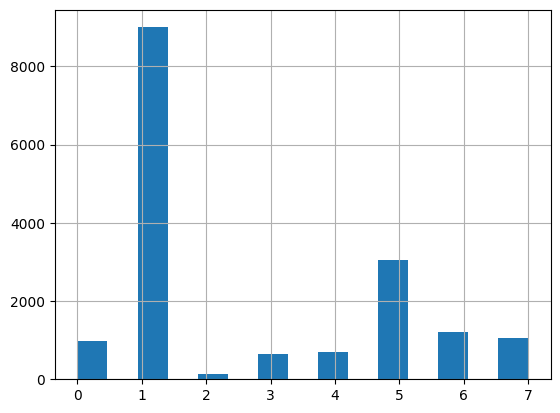

In [64]:
df['label_a'].hist(bins=15)

<Axes: >

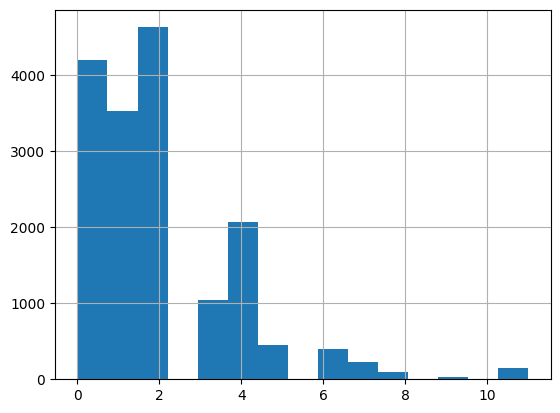

In [65]:
df['label_b'].hist(bins=15)

In [66]:
df['Ручная проверка карьерной ступени']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
16922   NaN
16923   NaN
16924   NaN
16925   NaN
16926   NaN
Name: Ручная проверка карьерной ступени, Length: 16804, dtype: float64

## Создадим категориальные фичи 
(Возраст, Пол, Регион, Страна проживания, Уровень образования, Соответствует ли выбранная типовая текущей должности)

In [67]:
cat_transformer = ColumnTransformer([('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)], 
                                    remainder='passthrough', verbose_feature_names_out=True)
cat_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['Вид экономической деятельности, ОКВЭД',
                                  'Доп вид экономической деятельности_1',
                                  'Доп вид экономической деятельности_2',
                                  'Доп вид экономической деятельности_3',
                                  'Уставный капитал, тип', 'Тип по ОКОГУ',
                                  'Категория из реестра СМП', 'Пол', 'Регион',
                                  'Страна проживания',
                                  'Уровень образования'])])

In [68]:
df_train.columns

Index(['Вид экономической деятельности, ОКВЭД',
       'Доп вид экономической деятельности_1',
       'Доп вид экономической деятельности_2',
       'Доп вид экономической деятельности_3', 'Уставный капитал, тип',
       'Тип по ОКОГУ', 'Категория из реестра СМП', 'Пол', 'Регион',
       'Страна проживания', 'Уровень образования', 'Место работы',
       'Наименование текущей должности', 'Уставный капитал, сумма',
       'Среднесписочная численность сотрудников',
       'Сумма уплаченных налогов за 2020', 'age'],
      dtype='object')

In [69]:
cat_transformer.fit_transform(df_train)

,"encoder__Вид экономической деятельности, ОКВЭД",encoder__Доп вид экономической деятельности_1,encoder__Доп вид экономической деятельности_2,encoder__Доп вид экономической деятельности_3,"encoder__Уставный капитал, тип",encoder__Тип по ОКОГУ,encoder__Категория из реестра СМП,encoder__Пол,encoder__Регион,encoder__Страна проживания,encoder__Уровень образования,remainder__Место работы,remainder__Наименование текущей должности,"remainder__Уставный капитал, сумма",remainder__Среднесписочная численность сотрудников,remainder__Сумма уплаченных налогов за 2020,remainder__age
3747,290.0,271.0,245.0,256.0,3.0,54.0,NaN,0.0,31.0,23.0,2.0,ООО Броневик Онлайн,Заместитель руководителя отельной группы,20000.0,36.0,8.439281e+07,37.0
16151,382.0,412.0,886.0,367.0,NaN,37.0,NaN,0.0,47.0,23.0,2.0,ФГБОУ ВО НГАСУ (Сибстрин),"Заместитель заведующего кафедры АРГС, старший ...",NaN,NaN,NaN,32.0
2780,935.0,11.0,544.0,1005.0,3.0,54.0,2.0,1.0,41.0,23.0,1.0,"ООО ""Сканойл Карт""","Советник генерального директора,Учредитель",2055000.0,8.0,4.521399e+07,40.0
14209,257.0,868.0,171.0,225.0,NaN,54.0,NaN,0.0,42.0,23.0,2.0,Ассоциация Производителей и Экспортеров Отечес...,Руководитель проектов,NaN,NaN,NaN,29.0
13606,166.0,NaN,NaN,NaN,NaN,14.0,NaN,1.0,71.0,23.0,2.0,Тульская областная Дума,Заместитель председателя комитета Тульской обл...,NaN,NaN,NaN,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8267,166.0,NaN,NaN,NaN,NaN,73.0,NaN,1.0,65.0,23.0,3.0,Аппарат Администрации Смоленской области,Помощник сенатора РФ представителя от Админист...,NaN,NaN,NaN,32.0
4367,13.0,920.0,973.0,979.0,3.0,54.0,NaN,1.0,41.0,23.0,2.0,ООО Группа компаний 1520,Начальник сектора,100000.0,238.0,3.421290e+08,30.0
1333,166.0,NaN,NaN,NaN,NaN,69.0,NaN,1.0,5.0,23.0,2.0,Министерство экономического развития Астраханс...,Первый заместитель министра,NaN,NaN,NaN,33.0
14740,450.0,108.0,192.0,104.0,NaN,54.0,NaN,1.0,61.0,23.0,1.0,Автономная некоммерческая организация по подде...,Директор,NaN,NaN,NaN,38.0


## Для текстовых полей низкой уникальности создадим фичи на основе эмбедингов
(Место работы, Наименование текущей должности, Наименование выбранной типовой должности, )

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
model = AutoModel.from_pretrained("ai-forever/ruBert-base").to(device)

In [71]:
df_train.shape, y_train[0].shape, y_train[1].shape, df_val.shape, y_val[0].shape, y_val[1].shape

((13443, 17), (13443,), (13443,), (3361, 17), (3361,), (3361,))

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin


class BERTEmbExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer=None, model=None, columns=None, batch_size=128):
        if tokenizer:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
            
        if model:
            self.model = model
        else:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.model = AutoModel.from_pretrained("ai-forever/ruBert-base").to(device)
            
        self.columns = columns
        self.batch_size = batch_size
        
    def bert_extract(self, X, col):
        out_emb = []
        total_samples = len(X)

        for start in tqdm(range(0, total_samples, self.batch_size)):
            end = min(start + self.batch_size, total_samples)
            
            batch_X = X[col].values[start:end]  # Extract a batch of data
            tokenized = tokenizer(batch_X.tolist(), padding = True, truncation = True, return_tensors="pt")
            column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}

            hidden_state = model(**column_tokens) #dim : [batch_size(nr_sentences), tokens, emb_dim]
            emb = hidden_state.last_hidden_state[:,0,:].to("cpu")
            del hidden_state
            
            df_emb = pd.DataFrame(emb, columns=[f'{col}_{i}' for i in range(emb.shape[1])])
            out_emb.append(df_emb)
            
        return pd.concat(out_emb)
    
    def fit(self, X, y=None):
        if not self.columns:
            self.columns = X.columns
        
        self.column_df_emb = {}
        self.column_pca = {}
        with torch.no_grad():
            for col in self.columns:
                df_emb = self.bert_extract(X, col)
                
                pca = PCA(0.99)
                pca.set_output(transform='pandas')
                
                df_emb = pca.fit_transform(df_emb)

                self.column_pca[col] = pca
            
        return self

    def transform(self, X, y=None):
        out = []
        with torch.no_grad():
            for col in self.columns:
                df_emb = self.bert_extract(X, col)
                df_emb = self.column_pca[col].transform(df_emb)
                df_emb.columns = [f'{col}_{pca_col}' for pca_col in df_emb.columns]
                out.append(df_emb)
        
        return pd.concat(out, axis=1)

## Обучим пайплайн

In [73]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer


In [74]:
data_transformer =  ColumnTransformer([
    ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('text_encoder', BERTEmbExtractor(tokenizer, model, batch_size=32), text_cols),
    ('num_features', 'passthrough', num_cols)
    ], remainder='drop', verbose_feature_names_out=True)

data_prepare = Pipeline([
    ('preproc', data_transformer),
    ('imputer', SimpleImputer()),
    ])

pipe = [Pipeline([
    ('model', ExtraTreesClassifier(class_weight='balanced_subsample', oob_score=True, bootstrap=True, n_jobs=5))
    ])
] * 2

In [76]:
%%time

X_train = data_prepare.fit_transform(df_train)
X_val = data_prepare.transform(df_val)
X_test = data_prepare.transform(df_test)

  0%|          | 0/421 [00:00<?, ?it/s]

/tmp/ipykernel_2895177/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/421 [00:00<?, ?it/s]/tmp/ipykernel_2895177/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) for k, v in tokenized.items()}
  0%|          | 0/421 [00:00<?, ?it/s]/tmp/ipykernel_2895177/2898017953.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(device) fo

CPU times: user 44.5 s, sys: 19.6 s, total: 1min 4s
Wall time: 25.3 s


In [78]:
%%time 

for i, task in enumerate(tasks):
    print(task)
    pipe[i].fit(X_train, y_train[i])
    print( "точность :" , pipe[i].score(X_val, y_val[i]))
    print()

Сфера деятельности по Классификатору ФОИР
точность : 0.6578399285926807

Карьерная ступень по Классификатору ФОИР
точность : 0.3469205593573341

CPU times: user 9.05 s, sys: 63.3 ms, total: 9.11 s
Wall time: 2.47 s


## Cross Val

In [83]:
%%time
for i, task in enumerate(tasks):
    print(task)
    print('точность :', cross_val_score(pipe[0], X_train, y_train[0], n_jobs=1))
    print()

Сфера деятельности по Классификатору ФОИР
точность : [0.63666791 0.63480848 0.64410562 0.63058036 0.64397321]

Карьерная ступень по Классификатору ФОИР
точность : [0.63666791 0.63741168 0.63480848 0.64508929 0.64397321]

CPU times: user 31.6 s, sys: 164 ms, total: 31.8 s
Wall time: 9.03 s


Попробуем регуляризацию и прунинг

In [81]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


In [82]:
def find_best_ccp_aplpha(X_train, y_train, X_val, y_val):
    print('Start compute cost_complexity_pruning_path')
    clf = DecisionTreeClassifier(random_state=0)
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    fig, ax = plt.subplots()
    ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
    ax.set_xlabel("effective alpha")
    ax.set_ylabel("total impurity of leaves")
    ax.set_title("Total Impurity vs effective alpha for training set")
    plt.show()
    
    print('Start searching best ccp alphas')
    ccp_alphas_select = ccp_alphas[np.linspace(0, len(ccp_alphas[:-15]), 30).astype(int)].tolist() + ccp_alphas[-15:].tolist()
    
    clfs = []
    for ccp_alpha in tqdm(ccp_alphas_select):
        clf = ExtraTreesClassifier(class_weight='balanced_subsample',
                                oob_score=True, 
                                bootstrap=True, 
                                n_jobs=5, 
                                random_state=0, 
                                ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)
    
    
    train_scores = [clf.score(X_train, y_train) for clf in clfs]
    test_scores = [clf.score(X_val, y_val) for clf in clfs]

    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas_select, train_scores, marker="o", label="train", drawstyle="steps-post")
    ax.plot(ccp_alphas_select, test_scores, marker="o", label="test", drawstyle="steps-post")
    ax.legend()
    plt.show()
    
    best_hyper = np.array(test_scores).argmax()
    print(f'best accuracy val: train {train_scores[best_hyper]} ,{test_scores[best_hyper]}') 
    best_ccp = ccp_alphas_select[best_hyper]
    
    print(f'Лучший коэф для прунинга {best_ccp}')
    
    return best_ccp

Карьерная ступень по Классификатору ФОИР

Сфера деятельности по Классификатору ФОИР

Start compute cost_complexity_pruning_path


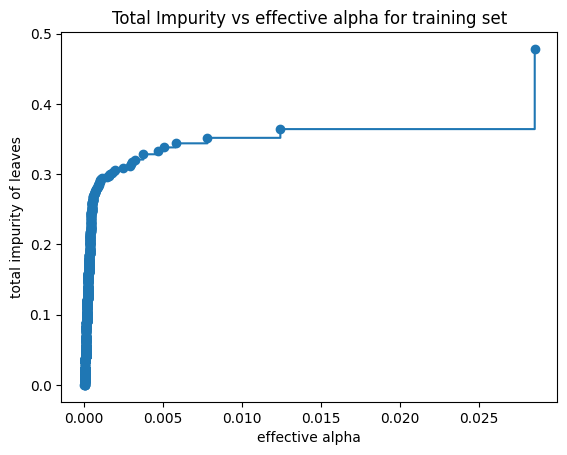

Start searching best ccp alphas


100%|██████████| 45/45 [01:02<00:00,  1.38s/it]


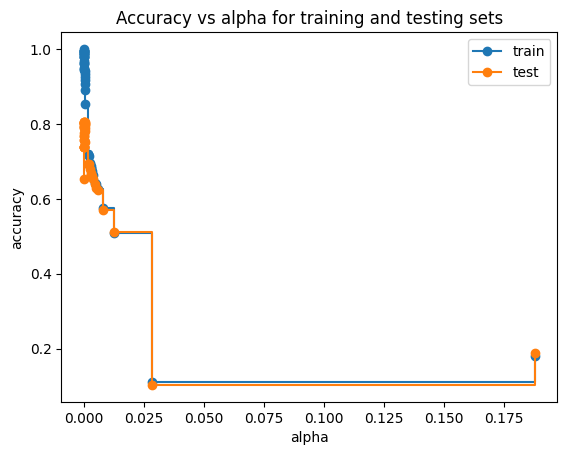

best accuracy val: train 0.9401175332887004 ,0.805117524546266
Лучший коэф для прунинга 0.00029755262962136424
точность : [0.78951283 0.79434734 0.7850502  0.78199405 0.79947917]

Карьерная ступень по Классификатору ФОИР

Start compute cost_complexity_pruning_path


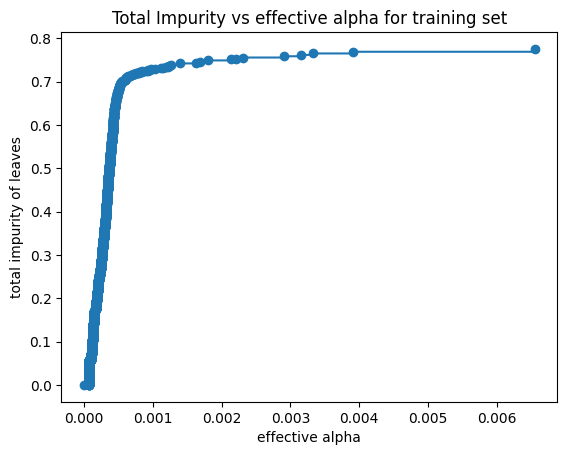

Start searching best ccp alphas


100%|██████████| 45/45 [01:37<00:00,  2.16s/it]


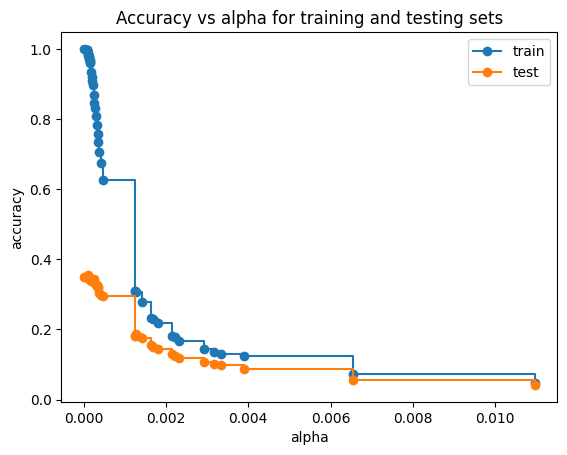

best accuracy val: train 0.9877259540281187 ,0.3546563522761083
Лучший коэф для прунинга 9.918420987378808e-05


/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


точность : [0.34957233 0.34622536 0.337672   0.34486607 0.35044643]



In [98]:
pipes = []

for i, task in enumerate(tasks):
    print(task)
    print()
    best_ccp = find_best_ccp_aplpha(X_train, y_train[i], X_val, y_val[i])
    
    pipe = Pipeline([
    ('model', ExtraTreesClassifier(class_weight='balanced_subsample', 
                                   oob_score=True, 
                                   bootstrap=True, 
                                   n_jobs=5, 
                                   ccp_alpha=best_ccp))
    ])
    
    print('точность :', cross_val_score(pipe, X_train, y_train[i], n_jobs=1))
    pipe.fit(X_train, y_train[i])
    pipes.append(pipe) 
    print()

## Метрики для - Сфера деятельности по Классификатору ФОИР

In [100]:
def metrics(pipe, X_val, y_val, LE):
    y_pred = pipe.predict(X_val)
    print(classification_report(y_val, y_pred,))

    display_labels = sorted(list(set(y_pred).union(y_val)))
    ConfusionMatrixDisplay.from_estimator(
        pipe, X_val, y_val, display_labels=LE.classes_[display_labels], xticks_rotation="vertical"
    )

In [99]:
tasks[0]

'Сфера деятельности по Классификатору ФОИР'

              precision    recall  f1-score   support

           0       0.49      0.26      0.34       174
           1       0.90      0.88      0.89      1822
           2       0.00      0.00      0.00        31
           3       0.67      0.28      0.40       120
           4       0.95      0.81      0.88       128
           5       0.61      0.90      0.73       631
           6       0.87      0.86      0.87       239
           7       0.87      0.65      0.74       216

    accuracy                           0.81      3361
   macro avg       0.67      0.58      0.61      3361
weighted avg       0.81      0.81      0.80      3361



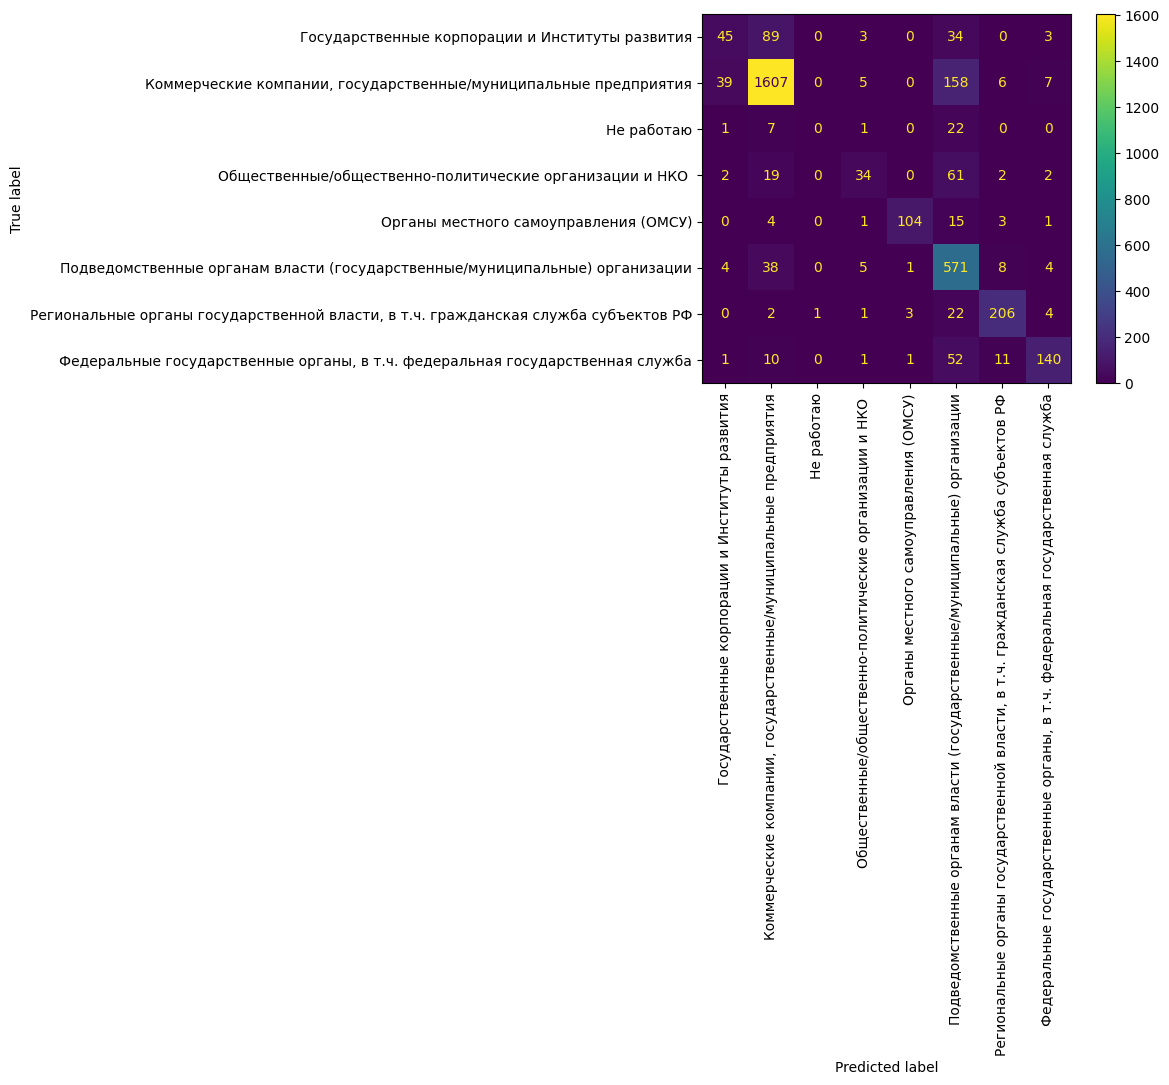

In [102]:
metrics(pipes[0], X_val, y_val[0], LE[0])

/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         3
           4       0.94      1.00      0.97        17
           5       0.44      0.78      0.56         9
           6       0.90      0.95      0.92        55
           7       0.96      0.71      0.81        34

    accuracy                           0.84       123
   macro avg       0.61      0.58      0.57       123
weighted avg       0.87      0.84      0.84       123



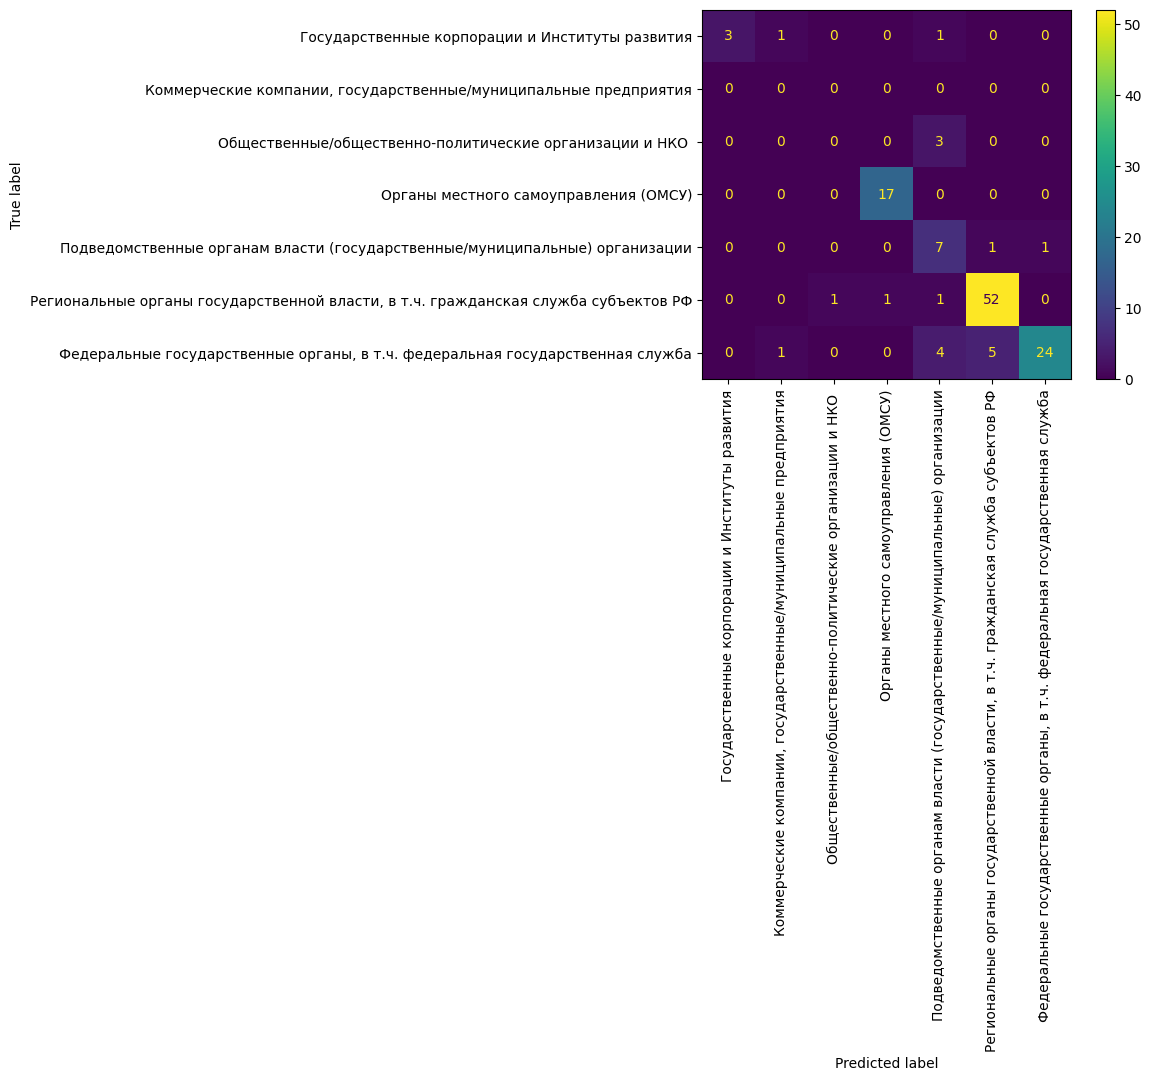

In [103]:
metrics(pipes[0], X_test, y_test[0], LE[0])

## Метрики для - Карьерная ступень по Классификатору ФОИР

In [104]:
tasks[1]

'Карьерная ступень по Классификатору ФОИР'

              precision    recall  f1-score   support

           0       0.36      0.51      0.42       823
           1       0.33      0.28      0.30       682
           2       0.36      0.53      0.43       952
           3       0.26      0.03      0.05       209
           4       0.32      0.14      0.19       424
           5       0.00      0.00      0.00        81
           6       0.33      0.01      0.02        79
           7       1.00      0.02      0.04        54
           8       0.00      0.00      0.00        21
           9       0.00      0.00      0.00         5
          11       0.00      0.00      0.00        31

    accuracy                           0.35      3361
   macro avg       0.27      0.14      0.13      3361
weighted avg       0.34      0.35      0.31      3361



/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

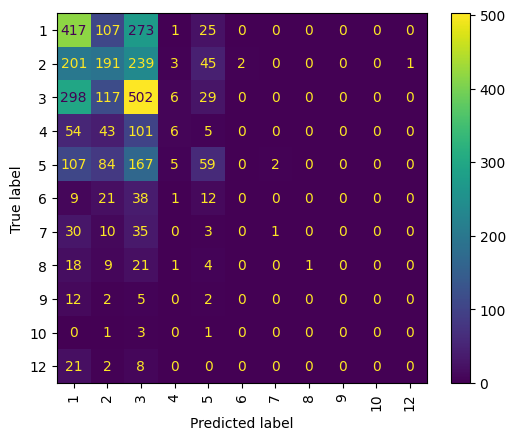

In [105]:
metrics(pipes[1], X_val, y_val[1], LE[1])

              precision    recall  f1-score   support

           0       0.07      0.60      0.13         5
           1       0.21      0.25      0.23        24
           2       0.07      0.25      0.11        12
           3       0.00      0.00      0.00        20
           4       0.50      0.14      0.21        22
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         3

    accuracy                           0.12       123
   macro avg       0.08      0.11      0.06       123
weighted avg       0.14      0.12      0.10       123



/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

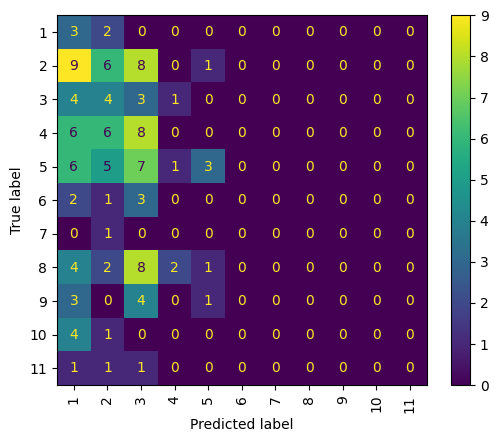

In [106]:
metrics(pipes[1], X_test, y_test[1], LE[1])

In [107]:
pipes

[Pipeline(steps=[('model',
                  ExtraTreesClassifier(bootstrap=True,
                                       ccp_alpha=0.00029755262962136424,
                                       class_weight='balanced_subsample',
                                       n_jobs=5, oob_score=True))]),
 Pipeline(steps=[('model',
                  ExtraTreesClassifier(bootstrap=True,
                                       ccp_alpha=9.918420987378808e-05,
                                       class_weight='balanced_subsample',
                                       n_jobs=5, oob_score=True))])]

In [109]:
import joblib

In [111]:
joblib.dump(pipes, '../twomodels.joblib')

['twomodels.joblib']

In [112]:
joblib.dump(data_transformer, '../data_transformer.joblib')

['../data_transformer.joblib']